# Pairs Trading
By: Mario Francisco Montana

First, we import the necessary libraries and load the datasets.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
date_format = lambda x : datetime.strptime(x, "%Y-%m-%d")

# Load the datasets and change format of Date column
df_inst1 = pd.read_csv("datasets/inst1.csv", parse_dates = ["Date"], date_parser = date_format)
df_inst2 = pd.read_csv("datasets/inst2.csv", parse_dates = ["Date"], date_parser = date_format)
df_inst3 = pd.read_csv("datasets/inst3.csv", parse_dates = ["Date"], date_parser = date_format)
df_inst4 = pd.read_csv("datasets/inst4.csv", parse_dates = ["Date"], date_parser = date_format)
df_inst5 = pd.read_csv("datasets/inst5.csv", parse_dates = ["Date"], date_parser = date_format)

dfs = [df_inst1, df_inst2, df_inst3, df_inst4, df_inst5]
all_names = ["inst1", "inst2", "inst3", "inst4", "inst5"]

Let's generate a plot of the "Settle" prices of the 5 financial instruments, each adjusted by its respective contract multiplier. The contract multiplier adjustment accounts for differences in contract size between these instruments, thus making the comparison meaningful.

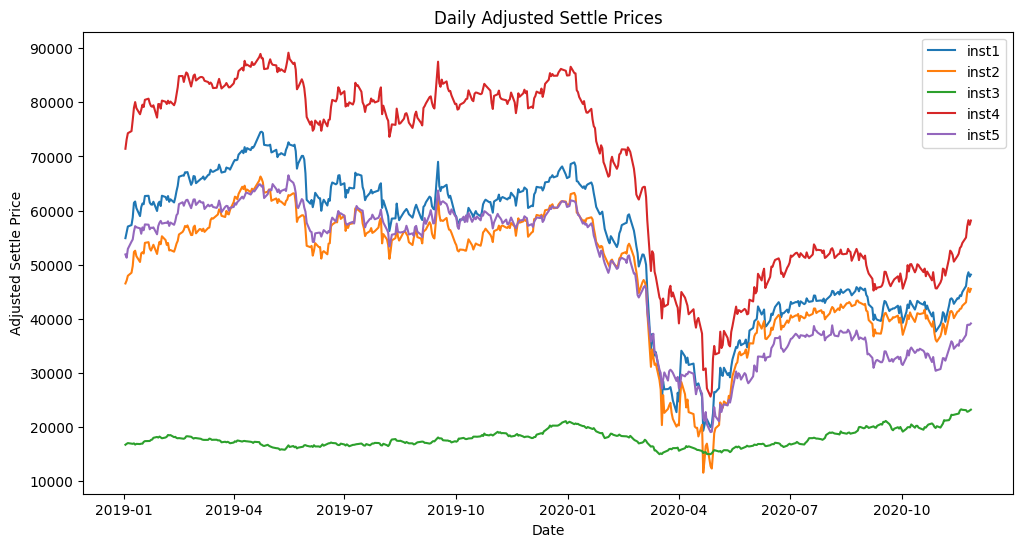

In [3]:
import matplotlib.pyplot as plt

multipliers = [1000, 1000, 600, 42000, 100]

plt.figure(figsize=(12, 6))

for i, df in enumerate(dfs):
    plt.plot(df["Date"], df["Settle"] * multipliers[i], label=all_names[i])

plt.title("Daily Adjusted Settle Prices")
plt.xlabel("Date")
plt.ylabel("Adjusted Settle Price")
plt.legend()
plt.show()

In [4]:
equal_dates = [inst["Date"].equals(dfs[0]["Date"]) for inst in dfs]
are_equal = np.all(equal_dates)

if are_equal:
    print("All dates are equal")
else:
    non_equal_series = [i + 1 for i, equal in enumerate(equal_dates) if not equal]
    print("Instrument not equal to others:", non_equal_series)

Instrument not equal to others: [3]


We observe that the "Date" column for instrument 3 is inconsistent with the other instruments, which is verified upon manual inspection. To resolve this inconsistency in the data, we edit its "Date" column by aligning it with that of the other instruments.

In [5]:
standard_date = df_inst1["Date"]
df_inst3 = df_inst3.merge(standard_date, on="Date", how="outer")
df_inst3 = df_inst3.sort_values(by="Date").reset_index(drop="True")

Next, we add a column "Daily Return" to the 5 dataframes. This column represents the percentage change in the value of each instrument from one day to the next.

In [6]:
dfs = [df_inst1, df_inst2, df_inst3, df_inst4, df_inst5]

for inst in dfs: 
    inst["Daily Return"] = inst["Settle"].pct_change(1)

We then generate the daily return series for each of the 5 instruments and their correlation matrix.

In [7]:
import seaborn as sns

returns_df = pd.DataFrame()

for i, df in enumerate(dfs, start=1):
    column_name = f"INST {i}"
    returns_df[column_name] = df["Daily Return"]

output_paths = ["inst1_returns.csv", "inst2_returns.csv", "inst3_returns.csv", "inst4_returns.csv", "inst5_returns.csv"]

for column, output_path in zip(returns_df.columns, output_paths):
    returns_df[column].dropna().to_csv(output_path, index=False)

correlation_matrix = returns_df.corr()

print(correlation_matrix)
correlation_matrix.to_csv("correlation_matrix.csv")

plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5)
plt.title("Correlation Matrix of Daily Returns")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

TypeError: NDFrame.to_csv() got an unexpected keyword argument 'path'

The lower correlation values between instrument 3 and the other instruments in the correlation matrix could be a result of the differences in returns calculation due to the initial unmatched dates and the subsequent filling of missing returns with zeros.

### Selection of Pairs

We proceed to perform a cointegration test on the Settle prices because correlation alone does not guarantee a long-term relationship between any 2 instruments. Cointegration analysis helps us determine whether there is a stable equilibrium relationship between any 2 instruments' returns over time, which is essential for pair trading strategies. By assessing the presence of cointegration, we can ascertain the potential for a mean-reverting behavior that can be exploited for trading opportunities.

In [ ]:
from statsmodels.tsa.stattools import coint

instrument_dfs = [df_inst1, df_inst2, df_inst3, df_inst4, df_inst5]
instruments = ["INST 1", "INST 2", "INST 3", "INST 4", "INST 5"]

pvalues_matrix = np.zeros((len(instruments), len(instruments)))

for i in range(len(instruments)):
    for j in range(i+1, len(instruments)):
        # Forward fill instead of dropping NaN values, assume price does not change
        _, pvalue, _ = coint(instrument_dfs[i]["Settle"].fillna(method="ffill"), instrument_dfs[j]["Settle"].fillna(method="ffill"))
        pvalues_matrix[i, j] = pvalue
        pvalues_matrix[j, i] = pvalue

pvalues_df = pd.DataFrame(pvalues_matrix, index=instruments, columns=instruments)
print(pvalues_df)

plt.figure(figsize=(6,4))
sns.heatmap(pvalues_df, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5)
plt.title("Cointegration Test P-values of Settle Prices")
plt.xlabel("Instruments")
plt.ylabel("Instruments")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

We see that the p-value of cointegration that is < 0.05 is between instrument 4 and instrument 5 (0.0018). Hence, we can be 95% certain that instruments 4 and 5 are cointegrated. We refer back to the correlation matrix of daily returns and observe that the value betweeen instrument 4 and instrument 5 is 0.8254, the 3rd highest among the pairs. This means that the price movement of instruments 4 and 5 is highly correlated and cointegrated. We proceed to choose this pair for our trading strategy.

### Creating and Visualizing the Trading Strategy

In the context of pairs trading, the spread can be defined as either the difference or the ratio between the prices of the two assets in the pair. We first look into calculating the spread using the difference of the 2 time series data using linear regression. The basic idea is to regress an instrument's price onto the other instrument's price and use the residuals of the regression as the spread. Below, instrument 4 is the regressor and instrument 5 is the dependent variable.

In [ ]:
import statsmodels.api as sm

S1 = df_inst4["Settle"]
S2 = df_inst5["Settle"]
date_series = df_inst4["Date"]


S1_diff = sm.add_constant(S1)
results = sm.OLS(S2, S1_diff).fit()
b = results.params[1]

spread = S2 - b * S1

plt.figure(figsize=(12, 6))
plt.plot(date_series, spread)
plt.axhline(spread.mean(), color = "black")
plt.legend(["Spread"])
plt.show()

Alternatively, we can use the ratio of the Settle prices to model the spread. For this strategy, we will be using the ratio of the price between instrument 4 and instrument 5.

In [ ]:
S1 = df_inst4["Settle"]
S2 = df_inst5["Settle"]
ratios = S1/S2
date_series = df_inst4["Date"]

plt.figure(figsize=(12, 6))
plt.plot(date_series, ratios)
plt.axhline(ratios.mean(), color = "black")
plt.legend(["Price Ratio"])
plt.show()

Stationarity is crucial in pairs trading as it ensures the stability of the price relationship between 2 assets. If the spread calculated is not stationary, it implies that the relationship between the assets is constantly changing, making it unreliable for pairs trading. In such cases, alternative ways to calculate the spread may need to be explored. Stationarity allows us to identify mean reversion opportunities and rely on historical patterns to determine entry and exit points. We can test for stationarity using the Augmented Dicky Fuller (ADF) Test.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(X, cutoff=0.05):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print("p-value = " + str(pvalue) + " The series is likely stationary.")
    else:
        print("p-value = " + str(pvalue) + " The series is likely non-stationary.")

stationarity_test(spread)
stationarity_test(ratios)

In [ ]:
zscore = (ratios - ratios.mean()) / ratios.std()

plt.figure(figsize=(12,6))
plt.plot(date_series, zscore)
plt.axhline(0, color="black")
plt.axhline(1.0, color="red", linestyle="--")
plt.axhline(-1.0, color="green", linestyle="--")
plt.legend(["Spread", "Mean", "+1", "-1"])
plt.show()

Since the ratio S1/S2 is non-stationary, the corresponding z scores will also be non-stationary. Hence, we will compute the z scores using rolling windows, namely the 5-day and 30-day moving averages. This approach takes into account the dynamic nature of the market and avoids relying on outdated information, allowing us to capture short-term trends amidst volatility in the market. For this approach, we will use the 5-day moving average to compute the z-score, while the 30-day moving average and standard deviation are utilized as the mean and standard deviation, respectively.

We adopt the following relatively simple strategy:

- "Long" the ratio whenever the z-score is below -1.0
- "Short" the ratio when the z-score is above 1.0
- Close these open positions when the z-score approaches 0. We set this threshold to 0.75

In [ ]:
ratios_mavg5 = ratios.rolling(window=5, center=False).mean()
ratios_mavg30 = ratios.rolling(window=30, center=False).mean()
std_30 = ratios.rolling(window=30, center=False).std()
zscore_30_5 = (ratios_mavg5 - ratios_mavg30)/std_30

plt.figure(figsize=(12, 6))
plt.plot(date_series, ratios.values)
plt.plot(date_series, ratios_mavg5.values)
plt.plot(date_series, ratios_mavg30.values)
plt.legend(["Ratio", "5d Ratio MA", "30d Ratio MA"])

plt.ylabel("Ratio")
plt.show()

In [ ]:
stationarity_test(zscore_30_5.dropna())

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(date_series, zscore_30_5)
plt.axhline(0, color="black")
plt.axhline(1.0, color="red", linestyle="--")
plt.axhline(-1.0, color="green", linestyle="--")
plt.legend(["Rolling Ratio z-Score", "Mean", "+1", "-1"])
plt.show()

We can visualize the buy/sell signals in the ratio plot as below,

In [ ]:
plt.figure(figsize=(12,6))

ratios.plot()
buy = ratios.copy()
sell = ratios.copy()
buy[zscore_30_5>-1] = 0
sell[zscore_30_5<1] = 0
buy[30:].plot(color="g", linestyle="None", marker="^")
sell[30:].plot(color="r", linestyle="None", marker="^")
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.legend(["Ratio", "Buy Signal", "Sell Signal"])
plt.show()

Moreover, we can visualize the specific buy/sell signals for each of the 2 instruments below. For simplicity, we will be assuming that we will be making trades based on the "Settle" prices of both instruments.

In [ ]:
plt.figure(figsize=(12,6))

(42000*S1).plot(color="b")
(100*S2).plot(color="c")
buy_ratio = 0*S1.copy()
sell_ratio = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buy_ratio[buy!=0] = (42000*S1)[buy!=0]
sell_ratio[buy!=0] = (100*S2)[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buy_ratio[sell!=0] = (100*S2)[sell!=0]
sell_ratio[sell!=0] = (42000*S1)[sell!=0]

buy_ratio[30:].plot(color="g", linestyle="None", marker="^")
sell_ratio[30:].plot(color="r", linestyle="None", marker="^")
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min((42000*S1).min(), (100*S2).min()), max((42000*S1).max(), (100*S2).max())))

plt.legend(["INST 4", "INST 5", "Buy Signal", "Sell Signal"])
plt.show()

### Evaluation of Trading Strategy

Let's write a function that simulates this trading strategy over all the available data and return the metrics. Utilizing all available data for training and evaluation allows us to capture comprehensive historical information and ensure the continuity of moving averages, which is heavily involved in this trading strategy. This approach enables us to leverage long-term trends and patterns, leading to more robust performance metrics and a reliable assessment of the trading strategy's effectiveness.

Moreover, since we are dealing with time series data, the temporal nature of data is crucial. The performance of the strategy often relies on capturing patterns and dynamics over time. In such cases, using all available data for training can provide a more comprehensive understanding of the time-dependent behavior.

As previously stated, we will assume that we will be trading on the "Settle" prices of both instruments.

In [ ]:
# Backtest Simulation
def trade(S1, S2, window1, window2, slippage=0.0005):

    if (window1 == 0) or (window2 == 0):
        return 0
    
    ratios = S1 / S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2) / std

    # Start with no money
    money = 0
    countS1 = 0
    countS2 = 0

    # To track portfolio values, max drawdown, and win ratio
    portfolio_values = []
    peak_portfolio_value = 0
    drawdowns = []
    wins = 0
    losses = 0
    open_portfolio_value = 0

    for i in range(len(ratios)):
        # Calculate portfolio value
        portfolio_value = money + S1[i] * countS1 + S2[i] * countS2
        portfolio_values.append(portfolio_value)
        
        if portfolio_value > peak_portfolio_value:
            peak_portfolio_value = portfolio_value
        drawdown = portfolio_value - peak_portfolio_value
        drawdowns.append(drawdown)

        # Trade logic
        # Buy long S1 (underpriced), sell short S2 (overpriced) if the z-score is < -1
        if zscore[i] < -1:
            trade_amount = (S1[i] - S2[i] * ratios[i]) * (1 + slippage)
            money -= trade_amount
            countS1 += 1
            countS2 -= ratios[i]
            open_portfolio_value = portfolio_value

        # Sell short S1 (overpriced), buy long S2 (underpriced) if the z-score is > 1 
        elif zscore[i] > 1:
            trade_amount = (S1[i] - S2[i] * ratios[i]) * (1 - slippage)
            money += trade_amount
            countS1 -= 1
            countS2 += ratios[i]
            open_portfolio_value = portfolio_value

        # Close open positions if the z-score is between -0.75 and 0.75
        elif abs(zscore[i]) < 0.75:
            # Check for win/loss
            if portfolio_value > open_portfolio_value:
                wins += 1
            elif portfolio_value < open_portfolio_value:
                losses += 1

            money += (S1[i] * countS1 + S2[i] * countS2) * (1 - slippage)
            countS1 = 0
            countS2 = 0

    zero_tuple = (0, 0, 0, 0, 0, 0, 0)
    trades = wins + losses
    trading_days = len(zscore.dropna())

    if trades == 0:  # prevent division by zero
        return zero_tuple
    
    # Total Return should include money and value of open positions at the end
    total_return = money + S1.iloc[-1] * countS1 + S2.iloc[-1] * countS2
    
    avg_trade_return = total_return / trades
    avg_daily_return = total_return / trading_days

    # Calculate annualized Sharpe ratio
    returns = np.diff(portfolio_values)  # get daily returns
    sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std()  # assume 252 trading days in a year

    # Calculate max drawdown
    max_drawdown = min(drawdowns) / peak_portfolio_value

    # Calculate win ratio
    win_ratio = wins / trades

    return total_return, trades, avg_trade_return, avg_daily_return, sharpe_ratio, max_drawdown, win_ratio


The metrics are computed below.

In [ ]:
total_return, trades, avg_trade_return, avg_daily_return, sharpe_ratio, max_drawdown, win_ratio = trade(42000*S1, 100*S2, 5, 30)

print("Total Returns: {:.2f}".format(total_return))
print("Trades: {}".format(trades))
print("Average Trade Return: {:.2f}".format(avg_trade_return))
print("Average Daily Return: {:.2f}".format(avg_daily_return))
print("Annualized Sharpe: {:.4f}".format(sharpe_ratio))
print("Max Drawdown: {:.2f}%".format(100*max_drawdown))
print("Win Ratio: {:.2f}%".format(100*win_ratio))

This seems to be a profitable trading strategy.

The total returns is positive, indicating significant profitability. The strategy also demonstrated active participation in the market, executing 276 trades^ over a trading period of 465 days (down from 494 days since we used the 30-day moving average so no trade can occur in the first 29 days). Both the average trade return and the average daily return are positive, reflecting consistent positive performance per individual trade and per trading day respectively. The annualized sharpe ratio is also > 1, assuming the risk-free rate is 0%. This indicates that the strategy has delivered excess returns per unit of risk compared to the risk-free rate. The maximum drawdown value of -18.76% is also at a relatively safe level since it is below 20%, a standard often set by traders. This suggests that at its lowest point, the portfolio experienced a decline of 18.76% from its previous peak value. The win^^ ratio is also fairly high at 93.48%, showing that majority of trades that close any open positions in the market resulted in profits.

However, it is important to consider the limitations of this evaluation. The strategy was implemented on all available data as train data and calculated the metrics on the same data, which can lead to overfitting and an optimistic assessment of its performance. Therefore, the real-world performance of the strategy may be worse than what is indicated by these metrics.

Lastly, we can optimize the value of the windows that optimize a specific metric by conducting a grid search. Below is an example in which this can be done. The function evaluates the "trade" function over a range of values for "window1" and "window2" and returns the window parameters that optimizes the annualized Sharpe ratio.

(*^ ^^Note: A "trade" is defined as both an entry and an exit. Furthermore, a "win" is defined to occur when a trade generates profits to the portfolio, whereas a loss occurs when a trade generates losses.*)

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define the range of windows to test
window1_range = range(5, 100, 5)  
window2_range = range(5, 100, 5)  

# Placeholder for the results
best_sharpe_ratio = -np.inf  # start with a very low best return
best_params = None

for window1 in window1_range:
    for window2 in window2_range:
        total_return, trades, avg_trade_return, avg_daily_return, sharpe_ratio, max_drawdown, win_ratio = trade(42000*S1, 100*S2, window1, window2)
        
        # If this pair of window values gives a higher Sharpe ratio than we've seen before, save it as the best pair
        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            best_params = (window1, window2)

print(f"The best window parameters are: {best_params} with a Sharpe ratio of: {best_sharpe_ratio}")